In [1]:
import pandas as pd
import seaborn as sns

sns.set()

In [2]:
N_PROD = 'Number of products'
TIME = 'Time (s)'
DEVICE = 'Device'
MODEL_TYPE = 'Architecture'

In [3]:
df_branched = pd.read_pickle('branched_models_results.pkl').rename(columns={
    'Branch layer': 'Architecture'
})

df_joint_vs_sep = pd.read_pickle('separate_inference_time_results.pkl')
branch_name = {
    'layer1': 'Layer 1 branch',
    'layer2': 'Layer 2 branch',
    'layer3': 'Layer 3 branch',
    'layer4': 'Layer 4 branch',
    'bbox_head': 'Bbox head branch',
    'roi_head': 'RoI head branch',
}
df_branched['Architecture'] = df_branched['Architecture'].apply(lambda x: branch_name[x])
df_all = pd.concat([df_joint_vs_sep, df_branched], ignore_index=True)

df_all = df_all[df_all['Device'] == 'cpu'].replace('cpu', 'CPU')

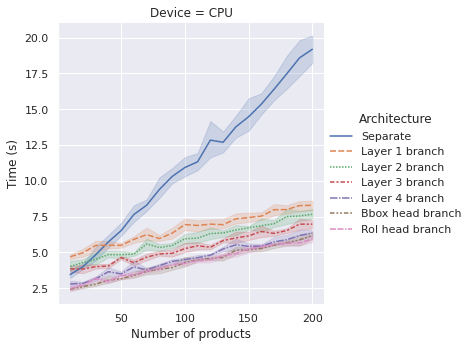

In [4]:
sns.relplot(data=df_all,
            x='Number of products', y='Time (s)',
            hue='Architecture',
            kind='line', style='Architecture', col='Device')

In [5]:
df_sep_vs_joint = (
    df_all[
        df_all['Architecture'].isin(['Separate', 'RoI head branch'])
    ].replace('RoI head branch', 'Joint')
)

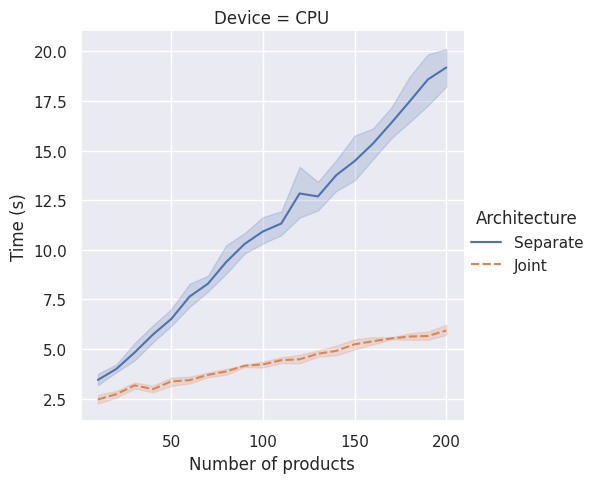

In [6]:
sns.relplot(data=df_sep_vs_joint,
            x='Number of products', y='Time (s)',
            hue='Architecture',
            kind='line', style='Architecture', col='Device')

## Linear regression

In [7]:
from sklearn.linear_model import LinearRegression

for t, group in df_all.groupby('Architecture'):
    print(f'{t}:')
    delay_per_prod = LinearRegression().fit(group['Number of products'].values[:, None], group['Time (s)']).coef_[0]
    n_prod = 10
    print(f'Delay per extra {n_prod} products: {delay_per_prod*n_prod*1000:.1f} ms\n')

Bbox head branch:
Delay per extra 10 products: 193.9 ms

Layer 1 branch:
Delay per extra 10 products: 184.1 ms

Layer 2 branch:
Delay per extra 10 products: 188.6 ms

Layer 3 branch:
Delay per extra 10 products: 174.7 ms

Layer 4 branch:
Delay per extra 10 products: 185.2 ms

RoI head branch:
Delay per extra 10 products: 179.5 ms

Separate:
Delay per extra 10 products: 824.8 ms



## Selection of num products

In [8]:
n_prods_select = [50, 100, 150, 200]

In [9]:
df_sep_vs_joint[
    df_sep_vs_joint[N_PROD].isin(n_prods_select)
].drop(columns=[DEVICE, 'Input size', 'Input size (recog)'])\
 .groupby([MODEL_TYPE, N_PROD])\
 .agg(['mean', 'std'])

Time (s)          
                                      mean       std
Architecture Number of products                     
Joint        50                   3.366984  0.262008
             100                  4.220978  0.192522
             150                  5.238759  0.299401
             200                  5.930075  0.347850
Separate     50                   6.514939  0.603429
             100                 10.924275  0.902293
             150                 14.470585  1.444224
             200                 19.186245  1.204433

In [10]:
df_sep_vs_joint_pv = (
    df_sep_vs_joint[df_sep_vs_joint[N_PROD].isin(n_prods_select)]
    .drop(columns=[DEVICE, 'Input size', 'Input size (recog)'])
    .pivot_table(values=TIME, index=MODEL_TYPE, columns=N_PROD, aggfunc=['mean', 'std'])
)
df_sep_vs_joint_pv

mean                                        std  \
Number of products       50         100        150        200       50    
Architecture                                                              
Joint               3.366984   4.220978   5.238759   5.930075  0.262008   
Separate            6.514939  10.924275  14.470585  19.186245  0.603429   

                                                  
Number of products       100       150       200  
Architecture                                      
Joint               0.192522  0.299401  0.347850  
Separate            0.902293  1.444224  1.204433

In [11]:
for arch, row in df_sep_vs_joint_pv.iterrows():
    for n_prod in n_prods_select:
        m = row['mean'][n_prod]
        s = row['std'][n_prod]
        print(fr'${m:.2f}\pm {s:.2f}$\\')

$3.37\pm 0.26$\\
$4.22\pm 0.19$\\
$5.24\pm 0.30$\\
$5.93\pm 0.35$\\
$6.51\pm 0.60$\\
$10.92\pm 0.90$\\
$14.47\pm 1.44$\\
$19.19\pm 1.20$\\


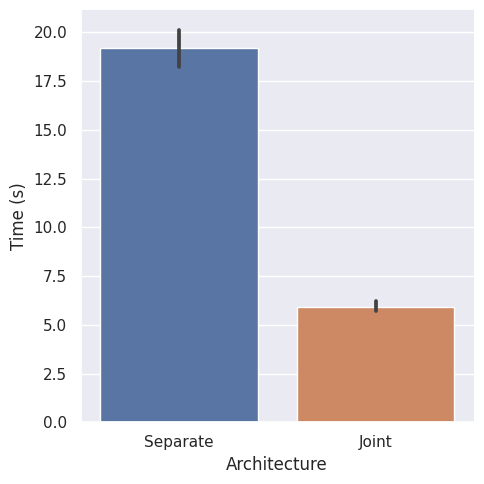

In [12]:
sns.catplot(data=df_sep_vs_joint[df_sep_vs_joint[N_PROD] == 200],
            x=MODEL_TYPE,
            y=TIME, kind="bar")

In [13]:
df_sep_vs_joint[df_sep_vs_joint[N_PROD] == 200].groupby(MODEL_TYPE).mean()

,Time (s),Input size,Input size (recog),Number of products
Architecture,,,,
Joint,5.930075,800.0,NaN,200.0
Separate,19.186245,800.0,224.0,200.0


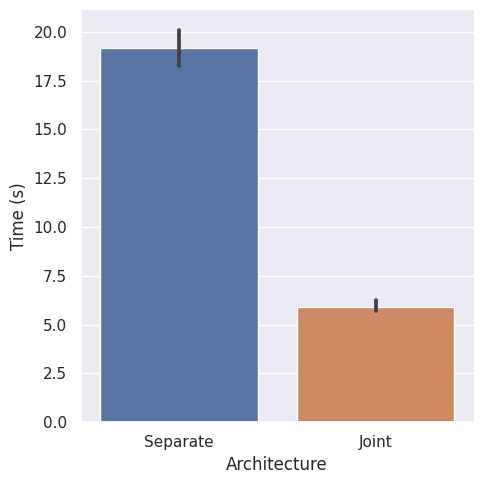

In [14]:
sns.catplot(data=df_sep_vs_joint[df_sep_vs_joint[N_PROD] == 200],
            x=MODEL_TYPE,
            y=TIME, kind="bar")

## Estimated model size of joint vs separate model

In [15]:
def get_model_size_mb(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    return (param_size + buffer_size) / 1024**2

In [16]:
# get_model_size_mb(faster_rcnn) + get_model_size_mb(rn50)
# get_model_size_mb(join_rcnn)